In [1]:
import rasterio
import rasterio.mask
import geopandas as gpd
from shapely import geometry

In [2]:
from rasterio.features import shapes

In [3]:
path = '../raw_data/raw_berlin/berlin_second_try.tif'

In [4]:
data = rasterio.open(path)
data.xy(row=10000,col=10000)

(1059005.0, 6899995.0)

In [5]:
with rasterio.open (path) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)

{'type': 'Polygon', 'coordinates': [[[20.252869, 58.167861], [19.893391, 57.146491], [21.357216, 57.146491], [21.743147, 58.167861], [20.252869, 58.167861]]]}
{'type': 'Polygon', 'coordinates': [[[16.679193, 56.135292], [16.410752, 55.133709], [20.658573, 55.133709], [20.996499, 56.135292], [16.679193, 56.135292]]]}
{'type': 'Polygon', 'coordinates': [[[15.172194, 61.29937], [12.814998, 51.213953], [26.177874, 51.213953], [30.993043, 61.29937], [15.172194, 61.29937]], [[20.252869, 58.167861], [19.893391, 57.146491], [21.357216, 57.146491], [21.743147, 58.167861], [20.252869, 58.167861]], [[16.679193, 56.135292], [16.410752, 55.133709], [20.658573, 55.133709], [20.996499, 56.135292], [16.679193, 56.135292]]]}


In [6]:
germany = gpd.read_file('../raw_data/germany.json')
berlin = germany[germany['NAME_3']=='Berlin'][['NAME_3','geometry']]
berlin

NAME_3                                           geometry
2028  Berlin  MULTIPOLYGON (((13.50020 52.61380, 13.49680 52...

In [7]:
berlin.total_bounds

array([13.0883, 52.3382, 13.7605, 52.6749])

In [8]:
p1 = geometry.Point(berlin.total_bounds[2], berlin.total_bounds[1])
p2 = geometry.Point(berlin.total_bounds[2], berlin.total_bounds[3])
p3 = geometry.Point(berlin.total_bounds[0], berlin.total_bounds[3])
p4 = geometry.Point(berlin.total_bounds[0], berlin.total_bounds[1])
pointlist = [p1, p2, p3, p4]
poly = geometry.Polygon([[p.x, p.y] for p in pointlist])
poly = gpd.GeoDataFrame(crs='epsg:4326', geometry=[poly]) #the crs of your points
poly2 = poly.to_crs('ESRI:54009') #the crs of your raster file
poly = poly.iloc[0]
poly2 = poly2.iloc[0]
poly = poly[0]
poly2 = poly2[0]
xx, yy = poly.exterior.coords.xy
print(xx)
print(yy)
xx, yy = poly2.exterior.coords.xy
print(xx)
print(yy)
p1 = geometry.Point(xx[0], yy[0])
p2 = geometry.Point(xx[1], yy[1])
p3 = geometry.Point(xx[2], yy[2])
p4 = geometry.Point(xx[3], yy[3])
pointlist = [p1, p2, p3, p4, p1]
poly = geometry.Polygon([[p.x, p.y] for p in pointlist])
polygons = [poly]
with rasterio.open("../raw_data/raw_berlin/berlin_second_try.tif") as src: #dont forget to add your filepath!
    out_image, out_transform = rasterio.mask.mask(src, polygons, crop = True)
out_meta = src.meta
out_meta.update({"driver": "GTiff",
"height": out_image.shape[1],
"width": out_image.shape[2],
"transform": out_transform})
with rasterio.open("../raw_data/raw_berlin/urban_class_berlin_proc.tif", "w", **out_meta) as dest:
    dest.write(out_image)

array('d', [13.7605, 13.7605, 13.0883, 13.0883, 13.7605])
array('d', [52.3382, 52.6749, 52.6749, 52.3382, 52.3382])
array('d', [1013665.0712782189, 1008765.0827774222, 959486.9396399647, 964147.5638538362, 1013665.0712782189])
array('d', [6116088.585836366, 6150647.188313356, 6150647.188313356, 6116088.585836366, 6116088.585836366])


In [9]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio

with rio.Env():
    with rio.open('../raw_data/raw_berlin/urban_class_berlin_proc.tif') as src:
        crs = src.crs

        # create 1D coordinate arrays (coordinates of the pixel center)
        xmin, ymax = np.around(src.xy(0.00, 0.00), 9)  # src.xy(0, 0)
        xmax, ymin = np.around(src.xy(src.height-1, src.width-1), 9)  # src.xy(src.width-1, src.height-1)
        x = np.linspace(xmin, xmax, src.width)
        y = np.linspace(ymax, ymin, src.height)  # max -> min so coords are top -> bottom



        # create 2D arrays
        xs, ys = np.meshgrid(x, y)
        zs = src.read(1)

        # Apply NoData mask
        mask = src.read_masks(1) > 0
        xs, ys, zs = xs[mask], ys[mask], zs[mask]

data = {"X": pd.Series(xs.ravel()),
        "Y": pd.Series(ys.ravel()),
        "Z": pd.Series(zs.ravel())}

df = pd.DataFrame(data=data)
geom = gpd.points_from_xy(df.X, df.Y)
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geom)

print(gdf.head())


          X          Y  Z                        geometry
0  959495.0  6150645.0  0  POINT (959495.000 6150645.000)
1  959505.0  6150645.0  0  POINT (959505.000 6150645.000)
2  959515.0  6150645.0  0  POINT (959515.000 6150645.000)
3  959525.0  6150645.0  0  POINT (959525.000 6150645.000)
4  959535.0  6150645.0  0  POINT (959535.000 6150645.000)


In [10]:
gdf.Z.unique()

array([ 0,  3, 11,  2,  1, 21,  5, 12, 13, 23,  4, 22, 24, 14, 25, 15],
      dtype=uint8)

In [11]:
gdf[gdf['Z']==255].index

Int64Index([], dtype='int64')

In [12]:
veg = gdf.apply(lambda x: 1 if x['Z']==1 else 2 if x['Z']==2 else 3 if x['Z']==3 else 0, axis=1)
road = gdf.apply(lambda x: 1 if x['Z']==5 else 0, axis=1)
water=gdf.apply(lambda x: 1 if x['Z']==4 else 0, axis=1)
resi = gdf.apply(lambda x: 1 if x['Z']==11 else 2 if x['Z']==12 else 3 if x['Z']==13 else 4 if x['Z']==14 else 5 if x['Z']==15 else 0, axis=1)
non_resi = gdf.apply(lambda x: 1 if x['Z']==21 else 2 if x['Z']==22 else 3 if x['Z']==23 else 4 if x['Z']==24 else 5 if x['Z']==25 else 0, axis=1)
gdf = gdf.drop(gdf[gdf['Z']==255].index)


In [13]:
berlin_urb_class = gpd.GeoDataFrame(list(zip(veg,road,water,resi,non_resi,gdf.geometry)),geometry=gdf.geometry,crs='ESRI:54009',
                                    columns = ['veg','road','water','resi','non_resi','geometry'])
berlin_urb_class.head()

veg  road  water  resi  non_resi                        geometry
0    0     0      0     0         0  POINT (959495.000 6150645.000)
1    0     0      0     0         0  POINT (959505.000 6150645.000)
2    0     0      0     0         0  POINT (959515.000 6150645.000)
3    0     0      0     0         0  POINT (959525.000 6150645.000)
4    0     0      0     0         0  POINT (959535.000 6150645.000)

In [14]:
berlin_urb_class.to_file('../raw_data/berlin_urban_class.json',driver='GeoJSONSeq')

In [15]:
berlin_urb_class

veg  road  water  resi  non_resi                         geometry
0           0     0      0     0         0   POINT (959495.000 6150645.000)
1           0     0      0     0         0   POINT (959505.000 6150645.000)
2           0     0      0     0         0   POINT (959515.000 6150645.000)
3           0     0      0     0         0   POINT (959525.000 6150645.000)
4           0     0      0     0         0   POINT (959535.000 6150645.000)
...       ...   ...    ...   ...       ...                              ...
17071878    0     0      0     0         0  POINT (1013615.000 6116095.000)
17071879    0     0      0     0         0  POINT (1013625.000 6116095.000)
17071880    0     0      0     0         0  POINT (1013635.000 6116095.000)
17071881    0     0      0     0         0  POINT (1013645.000 6116095.000)
17071882    0     0      0     0         0  POINT (1013655.000 6116095.000)

[17071883 rows x 6 columns]

In [68]:
berlin_urb_class.columns = ['veg','road','water','resi','non_resi','geometry']

ValueError: Length mismatch: Expected axis has 7 elements, new values have 6 elements

In [16]:
berlin_data = gpd.sjoin(berlin_urb_class,berlin.to_crs('ESRI:54009'))

In [82]:
berlin_data = berlin_data.drop(columns = ['index_right','NAME_3']).reset_index(drop=True)

In [18]:
berlin_data.to_file('../raw_data/berlin_urban_class.json',driver='GeoJSONSeq')

KeyboardInterrupt: 

In [19]:
from construct_grid import make_grid

In [20]:
berlin_grid = make_grid(berlin,100)

In [21]:
berlin_grid

geometry
0      POLYGON ((4569239.698 3253860.913, 4569339.698...
1      POLYGON ((4569339.698 3253860.913, 4569439.698...
2      POLYGON ((4569439.698 3253860.913, 4569539.698...
3      POLYGON ((4569539.698 3253860.913, 4569639.698...
4      POLYGON ((4569639.698 3253860.913, 4569739.698...
...                                                  ...
90503  POLYGON ((4556139.698 3290460.913, 4556239.698...
90504  POLYGON ((4555839.698 3290560.913, 4555939.698...
90505  POLYGON ((4555939.698 3290560.913, 4556039.698...
90506  POLYGON ((4556039.698 3290560.913, 4556139.698...
90507  POLYGON ((4556139.698 3290560.913, 4556239.698...

[90508 rows x 1 columns]

In [22]:
berlin_data = berlin_data.to_crs(epsg=3035)

In [27]:
berlin_data = berlin_data.drop(columns=['index_right','NAME_3'])

In [28]:
total_grid = gpd.sjoin(berlin_grid,berlin_data,predicate='intersects')

In [29]:
grouped_grid = total_grid.groupby(by=total_grid.index).sum()

/var/folders/dy/8nkgqf653sggg31kzy33mjdr0000gn/T/ipykernel_85285/1701297169.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_grid = total_grid.groupby(by=total_grid.index).sum()


In [30]:
grouped_grid = grouped_grid.drop(columns='index_right')
grouped_grid

veg  road  water  resi  non_resi
1        0     0      0     0         0
2        0     0      0     0         0
3        0     0      0     0         0
4        0     0      0     0         0
6        0     0      0     0         0
...    ...   ...    ...   ...       ...
90503    0     0      0     0         0
90504    0     0      0     0         0
90505    0     0      0     0         0
90506    0     0      0     0         0
90507    0     0      0     0         0

[90387 rows x 5 columns]

In [31]:
merged = pd.merge(grouped_grid,berlin_grid,left_index=True,right_index=True)

In [32]:
merged = merged.drop(columns='index_right')

KeyError: "['index_right'] not found in axis"

In [36]:
merged = gpd.GeoDataFrame(merged, geometry='geometry')

In [37]:
merged.to_file('../raw_data/berlin_urban_class.json',driver='GeoJSONSeq')

<Axes: >

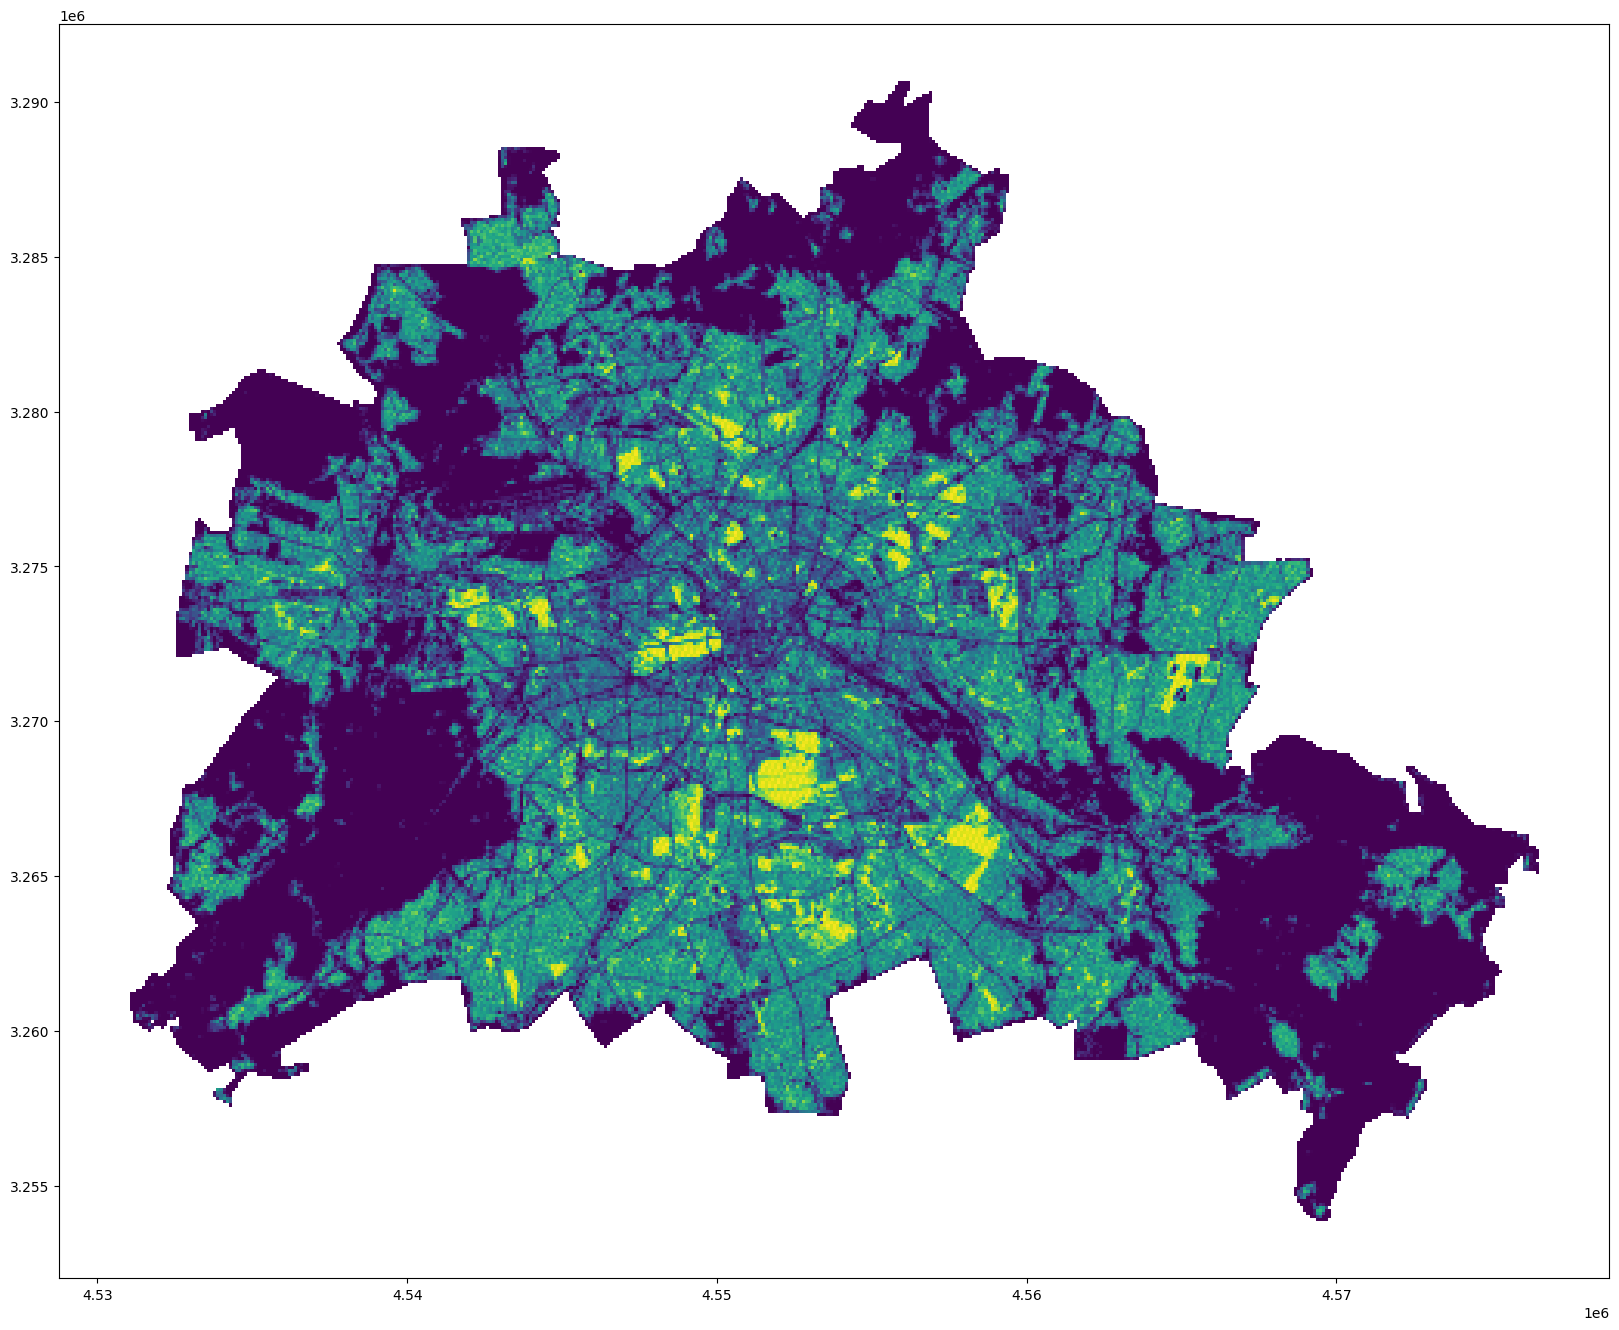

In [236]:
merged.plot(column='veg',figsize=(20,20))

In [46]:
merged.to_crs(epsg=4326).dissolve().centroid

/var/folders/dy/8nkgqf653sggg31kzy33mjdr0000gn/T/ipykernel_85285/1334935693.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged.to_crs(epsg=4326).dissolve().centroid


0    POINT (13.40198 52.50148)
dtype: geometry

In [127]:
merged.to_file('../raw_data/berlin_urban_class.json',driver='GeoJSONSeq')

In [128]:
test = gpd.read_file('../raw_data/berlin_urban_class.json')
test.shape

(90387, 6)

In [133]:
test2 = gpd.read_file('../raw_data/landuse_grid_Berlin.json')

In [134]:
test2.head(3)

code_2018                                         class_2018          area  \
0     11220  Discontinuous medium density urban fabric (S.L...  95051.225653   
1     11220  Discontinuous medium density urban fabric (S.L...  95051.225653   
2     11220  Discontinuous medium density urban fabric (S.L...  95051.225653   

                                            geometry  
0  POLYGON ((13.64540 52.34009, 13.64686 52.34005...  
1  POLYGON ((13.64547 52.34099, 13.64694 52.34094...  
2  POLYGON ((13.64840 52.34090, 13.64987 52.34085...

In [138]:
test2.shape

(71481, 4)

In [192]:
test.shape

(90387, 6)

In [193]:
test3.shape

(71481, 8)

In [140]:
test3 = gpd.sjoin(test,test2,predicate='within')
test3 = test3.drop(columns='index_right')
test3

veg  road  water  resi  non_resi  \
14     165     0      0    30         0   
15     181     0      0    39         0   
23     195     0      0    35         0   
24     204     0      0    29         0   
25     162     0      0    49         0   
...    ...   ...    ...   ...       ...   
90351    0     0      0     0         0   
90361    0     0      0     0         0   
90369    0     0      0     0         0   
90374    0     0      0     0         0   
90376    0     0      0     0         0   

                                                geometry code_2018  \
14     POLYGON ((13.64540 52.34009, 13.64686 52.34005...     11220   
15     POLYGON ((13.64686 52.34005, 13.64833 52.34000...     11220   
23     POLYGON ((13.64547 52.34099, 13.64694 52.34094...     11220   
24     POLYGON ((13.64694 52.34094, 13.64840 52.34090...     11220   
25     POLYGON ((13.64840 52.34090, 13.64987 52.34085...     11220   
...                                                  ...       ...   
90351  POLYGON ((13.47285 52.66910, 13.47433 52.66906...     32000   
90361  POLYGON ((13.47292 52.67000, 13.47440 52.66995...     23000   
90369  POLYGON ((13.47299 52.67089, 13.47447 52.67085...     23000   
90374  POLYGON ((13.47306 52.67179, 13.47454 52.67175...     23000   
90376  POLYGON ((13.47602 52.67171, 13.47749 52.67166...     32000   

                                              class_2018          area  
14     Discontinuous medium density urban fabric (S.L...  95051.225653  
15     Discontinuous medium density urban fabric (S.L...  26392.319278  
23     Discontinuous medium density urban fabric (S.L...  95051.225653  
24     Discontinuous medium density urban fabric (S.L...  26392.319278  
25     Discontinuous medium density urban fabric (S.L...  95051.225653  
...                                                  ...           ...  
90351  Herbaceous vegetation associations (natural gr...  13737.505410  
90361                                           Pastures  25948.699349  
90369                                           Pastures  25948.699349  
90374                                           Pastures  25948.699349  
90376  Herbaceous vegetation associations (natural gr...  11678.106351  

[71481 rows x 9 columns]

In [142]:
test3 = test3.reset_index(drop=True)
test3 = test3.drop(columns = 'class_2018')

In [143]:
test3

veg  road  water  resi  non_resi  \
0      165     0      0    30         0   
1      181     0      0    39         0   
2      195     0      0    35         0   
3      204     0      0    29         0   
4      162     0      0    49         0   
...    ...   ...    ...   ...       ...   
71476    0     0      0     0         0   
71477    0     0      0     0         0   
71478    0     0      0     0         0   
71479    0     0      0     0         0   
71480    0     0      0     0         0   

                                                geometry code_2018  \
0      POLYGON ((13.64540 52.34009, 13.64686 52.34005...     11220   
1      POLYGON ((13.64686 52.34005, 13.64833 52.34000...     11220   
2      POLYGON ((13.64547 52.34099, 13.64694 52.34094...     11220   
3      POLYGON ((13.64694 52.34094, 13.64840 52.34090...     11220   
4      POLYGON ((13.64840 52.34090, 13.64987 52.34085...     11220   
...                                                  ...       ...   
71476  POLYGON ((13.47285 52.66910, 13.47433 52.66906...     32000   
71477  POLYGON ((13.47292 52.67000, 13.47440 52.66995...     23000   
71478  POLYGON ((13.47299 52.67089, 13.47447 52.67085...     23000   
71479  POLYGON ((13.47306 52.67179, 13.47454 52.67175...     23000   
71480  POLYGON ((13.47602 52.67171, 13.47749 52.67166...     32000   

               area  
0      95051.225653  
1      26392.319278  
2      95051.225653  
3      26392.319278  
4      95051.225653  
...             ...  
71476  13737.505410  
71477  25948.699349  
71478  25948.699349  
71479  25948.699349  
71480  11678.106351  

[71481 rows x 8 columns]

In [144]:
test3.to_file('../raw_data/berlin_urban_class.json',driver='GeoJSONSeq')

<Axes: >

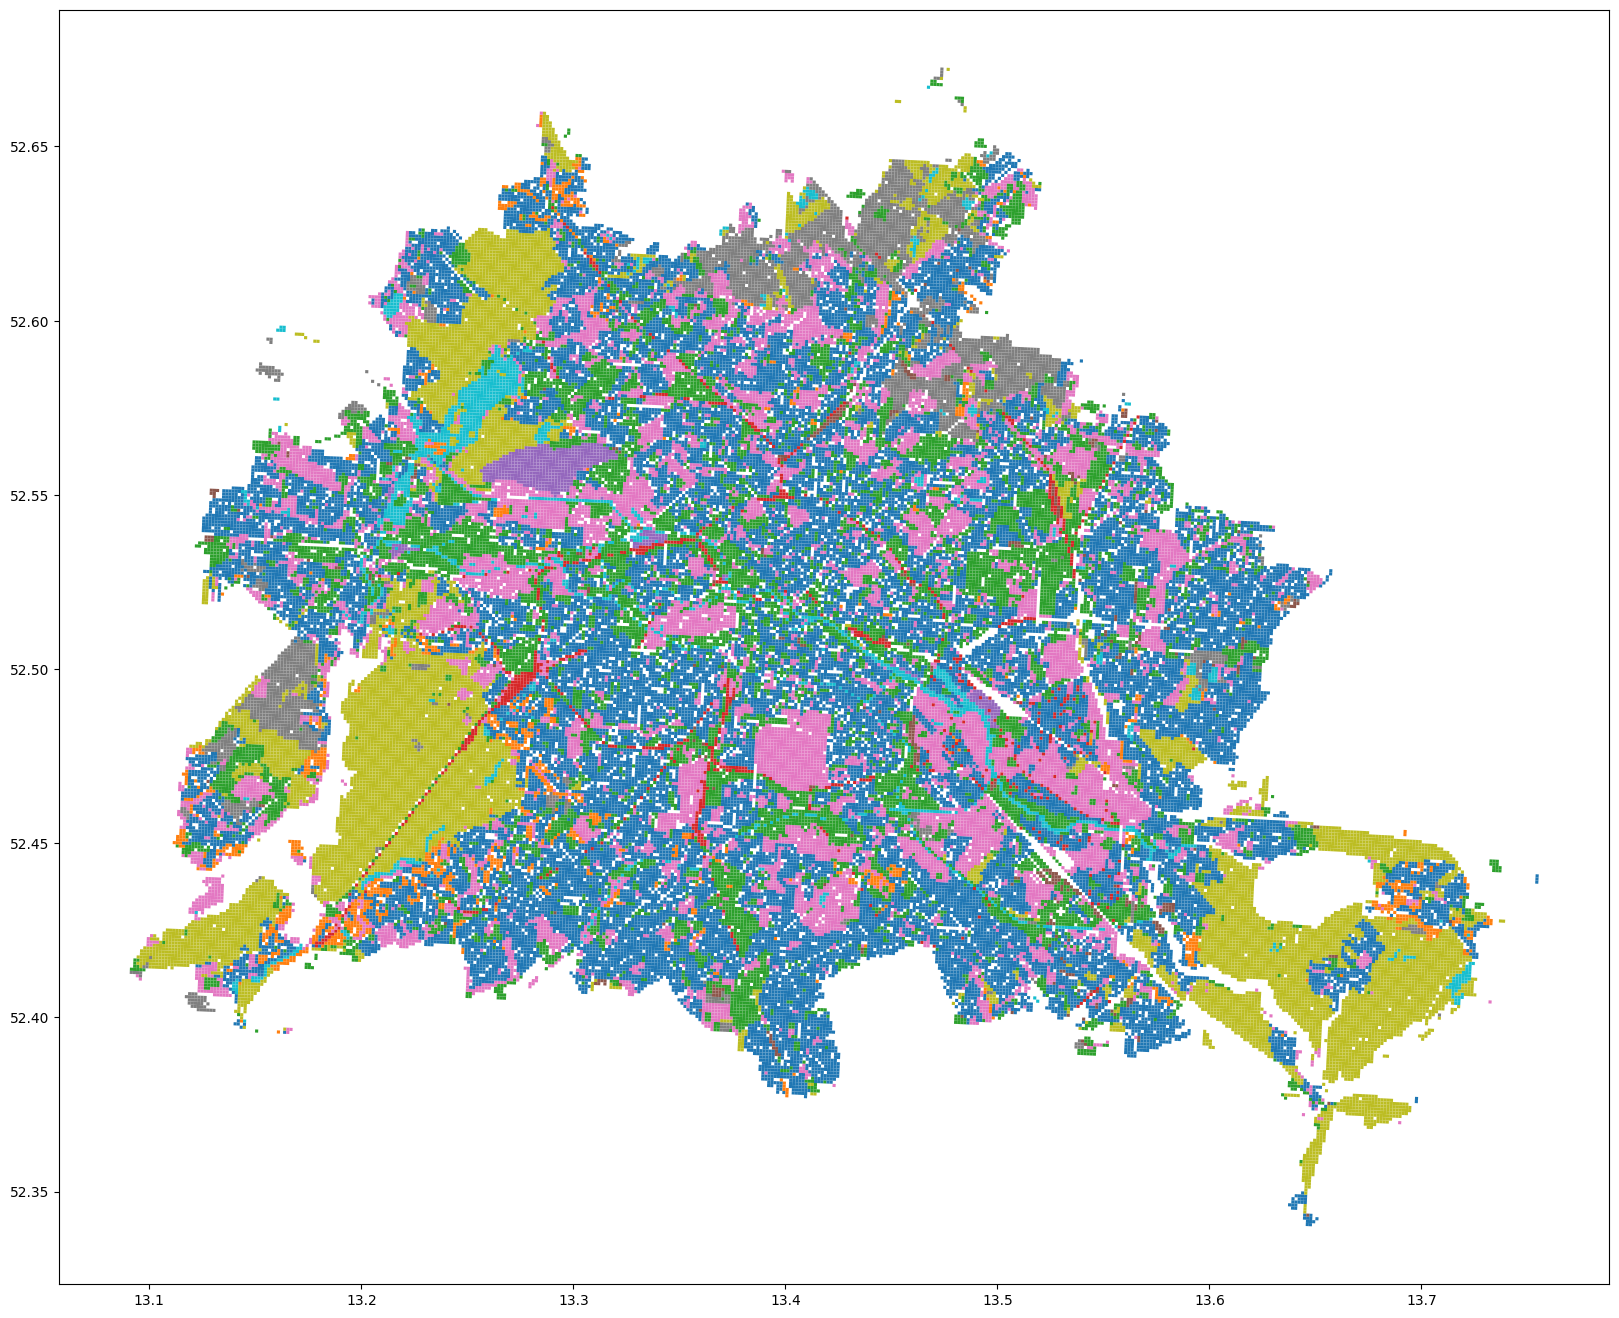

In [152]:
test3.plot(column='code_2018', figsize=(20,20))

## BERLIN POP

In [155]:
geometry

<GeometryArray>
[ <POINT (959495 6150645)>,  <POINT (959505 6150645)>,
  <POINT (959515 6150645)>,  <POINT (959525 6150645)>,
  <POINT (959535 6150645)>,  <POINT (959545 6150645)>,
  <POINT (959555 6150645)>,  <POINT (959565 6150645)>,
  <POINT (959575 6150645)>,  <POINT (959585 6150645)>,
 ...
 <POINT (1013565 6116095)>, <POINT (1013575 6116095)>,
 <POINT (1013585 6116095)>, <POINT (1013595 6116095)>,
 <POINT (1013605 6116095)>, <POINT (1013615 6116095)>,
 <POINT (1013625 6116095)>, <POINT (1013635 6116095)>,
 <POINT (1013645 6116095)>, <POINT (1013655 6116095)>]
Length: 17071883, dtype: geometry

In [157]:
p1 = geometry.Point(berlin.total_bounds[2], berlin.total_bounds[1])
p2 = geometry.Point(berlin.total_bounds[2], berlin.total_bounds[3])
p3 = geometry.Point(berlin.total_bounds[0], berlin.total_bounds[3])
p4 = geometry.Point(berlin.total_bounds[0], berlin.total_bounds[1])
pointlist = [p1, p2, p3, p4]
poly = geometry.Polygon([[p.x, p.y] for p in pointlist])
poly = gpd.GeoDataFrame(crs='epsg:4326', geometry=[poly]) #the crs of your points
poly2 = poly.to_crs('ESRI:54009') #the crs of your raster file
poly = poly.iloc[0]
poly2 = poly2.iloc[0]
poly = poly[0]
poly2 = poly2[0]
xx, yy = poly.exterior.coords.xy
print(xx)
print(yy)
xx, yy = poly2.exterior.coords.xy
print(xx)
print(yy)
p1 = geometry.Point(xx[0], yy[0])
p2 = geometry.Point(xx[1], yy[1])
p3 = geometry.Point(xx[2], yy[2])
p4 = geometry.Point(xx[3], yy[3])
pointlist = [p1, p2, p3, p4, p1]
poly = geometry.Polygon([[p.x, p.y] for p in pointlist])
polygons = [poly]
with rasterio.open("../raw_data/raw_berlin/berlin_pop.tif") as src: #dont forget to add your filepath!
    out_image, out_transform = rasterio.mask.mask(src, polygons, crop = True)
out_meta = src.meta
out_meta.update({"driver": "GTiff",
"height": out_image.shape[1],
"width": out_image.shape[2],
"transform": out_transform})
with rasterio.open("../raw_data/raw_berlin/pop_berlin_proc.tif", "w", **out_meta) as dest:
    dest.write(out_image)

array('d', [13.7605, 13.7605, 13.0883, 13.0883, 13.7605])
array('d', [52.3382, 52.6749, 52.6749, 52.3382, 52.3382])
array('d', [1013665.0712782189, 1008765.0827774222, 959486.9396399647, 964147.5638538362, 1013665.0712782189])
array('d', [6116088.585836366, 6150647.188313356, 6150647.188313356, 6116088.585836366, 6116088.585836366])


In [158]:
with rio.Env():
    with rio.open('../raw_data/raw_berlin/pop_berlin_proc.tif') as src:
        crs = src.crs

        # create 1D coordinate arrays (coordinates of the pixel center)
        xmin, ymax = np.around(src.xy(0.00, 0.00), 9)  # src.xy(0, 0)
        xmax, ymin = np.around(src.xy(src.height-1, src.width-1), 9)  # src.xy(src.width-1, src.height-1)
        x = np.linspace(xmin, xmax, src.width)
        y = np.linspace(ymax, ymin, src.height)  # max -> min so coords are top -> bottom



        # create 2D arrays
        xs, ys = np.meshgrid(x, y)
        zs = src.read(1)

        # Apply NoData mask
        mask = src.read_masks(1) > 0
        xs, ys, zs = xs[mask], ys[mask], zs[mask]

data = {"X": pd.Series(xs.ravel()),
        "Y": pd.Series(ys.ravel()),
        "Z": pd.Series(zs.ravel())}

df = pd.DataFrame(data=data)
geom = gpd.points_from_xy(df.X, df.Y)
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geom)

print(gdf.head())

          X          Y    Z                        geometry
0  959550.0  6150550.0  0.0  POINT (959550.000 6150550.000)
1  959650.0  6150550.0  0.0  POINT (959650.000 6150550.000)
2  959750.0  6150550.0  0.0  POINT (959750.000 6150550.000)
3  959850.0  6150550.0  0.0  POINT (959850.000 6150550.000)
4  959950.0  6150550.0  0.0  POINT (959950.000 6150550.000)


In [162]:
gdf = gdf.to_crs(epsg=3035)
pop_mesh = gpd.sjoin(gdf,berlin.to_crs(epsg=3035))
pop_mesh

X          Y          Z                         geometry  \
283      987850.0  6150550.0   0.000000  POINT (4555960.030 3290607.318)   
284      987950.0  6150550.0   0.000000  POINT (4556052.179 3290611.726)   
775      987750.0  6150450.0   0.000000  POINT (4555860.237 3290493.835)   
776      987850.0  6150450.0   0.000000  POINT (4555952.387 3290498.241)   
777      987950.0  6150450.0   0.000000  POINT (4556044.537 3290502.649)   
...           ...        ...        ...                              ...   
169842  1005350.0  6116250.0  43.574783  POINT (4569513.745 3254033.867)   
169843  1005450.0  6116250.0   0.113772  POINT (4569606.136 3254038.502)   
169844  1005550.0  6116250.0   0.000000  POINT (4569698.528 3254043.139)   
170337  1005350.0  6116150.0   0.000000  POINT (4569506.264 3253925.074)   
170338  1005450.0  6116150.0   0.000000  POINT (4569598.656 3253929.709)   

        index_right  NAME_3  
283            2028  Berlin  
284            2028  Berlin  
775            2028  Berlin  
776            2028  Berlin  
777            2028  Berlin  
...             ...     ...  
169842         2028  Berlin  
169843         2028  Berlin  
169844         2028  Berlin  
170337         2028  Berlin  
170338         2028  Berlin  

[88991 rows x 6 columns]

In [163]:
pop_mesh = pop_mesh.drop(columns=['index_right','NAME_3']).reset_index(drop=True)

In [164]:
pop_gridmesh = gpd.sjoin(berlin_grid,pop_mesh,predicate='intersects')
pop_gridmesh

geometry  index_right  \
2      POLYGON ((4569439.698 3253860.913, 4569539.698...        88989   
3      POLYGON ((4569539.698 3253860.913, 4569639.698...        88990   
6      POLYGON ((4569139.698 3253960.913, 4569239.698...        88983   
7      POLYGON ((4569239.698 3253960.913, 4569339.698...        88984   
8      POLYGON ((4569339.698 3253960.913, 4569439.698...        88985   
...                                                  ...          ...   
90501  POLYGON ((4555939.698 3290460.913, 4556039.698...            3   
90502  POLYGON ((4556039.698 3290460.913, 4556139.698...            4   
90502  POLYGON ((4556039.698 3290460.913, 4556139.698...            5   
90505  POLYGON ((4555939.698 3290560.913, 4556039.698...            0   
90506  POLYGON ((4556039.698 3290560.913, 4556139.698...            1   

               X          Y          Z  
2      1005350.0  6116150.0   0.000000  
3      1005450.0  6116150.0   0.000000  
6      1005050.0  6116250.0   0.000000  
7      1005150.0  6116250.0   0.540418  
8      1005250.0  6116250.0  22.327810  
...          ...        ...        ...  
90501   987850.0  6150450.0   0.000000  
90502   987950.0  6150450.0   0.000000  
90502   988050.0  6150450.0   0.000000  
90505   987850.0  6150550.0   0.000000  
90506   987950.0  6150550.0   0.000000  

[88990 rows x 5 columns]

<Axes: >

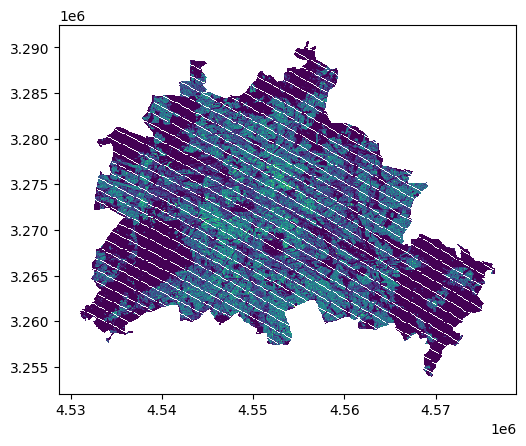

In [166]:
pop_gridmesh.plot(column='Z')

In [168]:
pop_gridmesh = pop_gridmesh.drop(columns = ['index_right','X','Y'])

In [180]:
test3

veg  road  water  resi  non_resi  \
0      165     0      0    30         0   
1      181     0      0    39         0   
2      195     0      0    35         0   
3      204     0      0    29         0   
4      162     0      0    49         0   
...    ...   ...    ...   ...       ...   
71476    0     0      0     0         0   
71477    0     0      0     0         0   
71478    0     0      0     0         0   
71479    0     0      0     0         0   
71480    0     0      0     0         0   

                                                geometry code_2018  \
0      POLYGON ((13.64540 52.34009, 13.64686 52.34005...     11220   
1      POLYGON ((13.64686 52.34005, 13.64833 52.34000...     11220   
2      POLYGON ((13.64547 52.34099, 13.64694 52.34094...     11220   
3      POLYGON ((13.64694 52.34094, 13.64840 52.34090...     11220   
4      POLYGON ((13.64840 52.34090, 13.64987 52.34085...     11220   
...                                                  ...       ...   
71476  POLYGON ((13.47285 52.66910, 13.47433 52.66906...     32000   
71477  POLYGON ((13.47292 52.67000, 13.47440 52.66995...     23000   
71478  POLYGON ((13.47299 52.67089, 13.47447 52.67085...     23000   
71479  POLYGON ((13.47306 52.67179, 13.47454 52.67175...     23000   
71480  POLYGON ((13.47602 52.67171, 13.47749 52.67166...     32000   

               area  
0      95051.225653  
1      26392.319278  
2      95051.225653  
3      26392.319278  
4      95051.225653  
...             ...  
71476  13737.505410  
71477  25948.699349  
71478  25948.699349  
71479  25948.699349  
71480  11678.106351  

[71481 rows x 8 columns]

In [194]:
more_berlin = gpd.sjoin(test3,pop_gridmesh.to_crs(epsg=4326), predicate='intersects')
more_berlin

veg  road  water  resi  non_resi  \
0      165     0      0    30         0   
1      181     0      0    39         0   
0      165     0      0    30         0   
1      181     0      0    39         0   
0      165     0      0    30         0   
...    ...   ...    ...   ...       ...   
71479    0     0      0     0         0   
71479    0     0      0     0         0   
71480    0     0      0     0         0   
71480    0     0      0     0         0   
71480    0     0      0     0         0   

                                                geometry code_2018  \
0      POLYGON ((13.64540 52.34009, 13.64686 52.34005...     11220   
1      POLYGON ((13.64686 52.34005, 13.64833 52.34000...     11220   
0      POLYGON ((13.64540 52.34009, 13.64686 52.34005...     11220   
1      POLYGON ((13.64686 52.34005, 13.64833 52.34000...     11220   
0      POLYGON ((13.64540 52.34009, 13.64686 52.34005...     11220   
...                                                  ...       ...   
71479  POLYGON ((13.47306 52.67179, 13.47454 52.67175...     23000   
71479  POLYGON ((13.47306 52.67179, 13.47454 52.67175...     23000   
71480  POLYGON ((13.47602 52.67171, 13.47749 52.67166...     32000   
71480  POLYGON ((13.47602 52.67171, 13.47749 52.67166...     32000   
71480  POLYGON ((13.47602 52.67171, 13.47749 52.67166...     32000   

               area  index_right          Z  
0      95051.225653           17  90.136093  
1      26392.319278           17  90.136093  
0      95051.225653           16  59.901108  
1      26392.319278           16  59.901108  
0      95051.225653           25  44.143646  
...             ...          ...        ...  
71479  25948.699349        90501   0.000000  
71479  25948.699349        90500   0.000000  
71480  11678.106351        90497   0.000000  
71480  11678.106351        90502   0.000000  
71480  11678.106351        90502   0.000000  

[356436 rows x 10 columns]

In [195]:
more_berlin.drop(columns='index_right',inplace=True)
more_berlin.columns = ['veg','roads','water','height_resid','height_nonresid','geometry','land_use_code',
                       'land_use_area','population']
more_berlin

veg  roads  water  height_resid  height_nonresid  \
0      165      0      0            30                0   
1      181      0      0            39                0   
0      165      0      0            30                0   
1      181      0      0            39                0   
0      165      0      0            30                0   
...    ...    ...    ...           ...              ...   
71479    0      0      0             0                0   
71479    0      0      0             0                0   
71480    0      0      0             0                0   
71480    0      0      0             0                0   
71480    0      0      0             0                0   

                                                geometry land_use_code  \
0      POLYGON ((13.64540 52.34009, 13.64686 52.34005...         11220   
1      POLYGON ((13.64686 52.34005, 13.64833 52.34000...         11220   
0      POLYGON ((13.64540 52.34009, 13.64686 52.34005...         11220   
1      POLYGON ((13.64686 52.34005, 13.64833 52.34000...         11220   
0      POLYGON ((13.64540 52.34009, 13.64686 52.34005...         11220   
...                                                  ...           ...   
71479  POLYGON ((13.47306 52.67179, 13.47454 52.67175...         23000   
71479  POLYGON ((13.47306 52.67179, 13.47454 52.67175...         23000   
71480  POLYGON ((13.47602 52.67171, 13.47749 52.67166...         32000   
71480  POLYGON ((13.47602 52.67171, 13.47749 52.67166...         32000   
71480  POLYGON ((13.47602 52.67171, 13.47749 52.67166...         32000   

       land_use_area  population  
0       95051.225653   90.136093  
1       26392.319278   90.136093  
0       95051.225653   59.901108  
1       26392.319278   59.901108  
0       95051.225653   44.143646  
...              ...         ...  
71479   25948.699349    0.000000  
71479   25948.699349    0.000000  
71480   11678.106351    0.000000  
71480   11678.106351    0.000000  
71480   11678.106351    0.000000  

[356436 rows x 9 columns]

<Axes: >

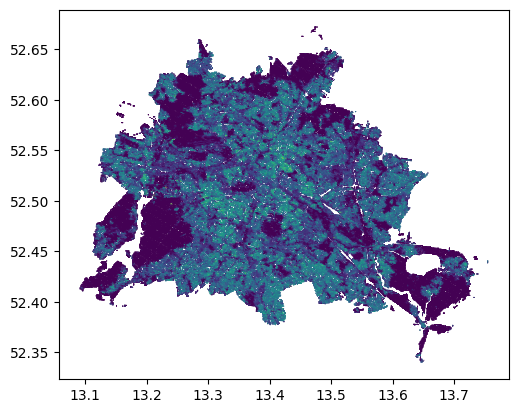

In [197]:
more_berlin.plot(column='population')

<Axes: >

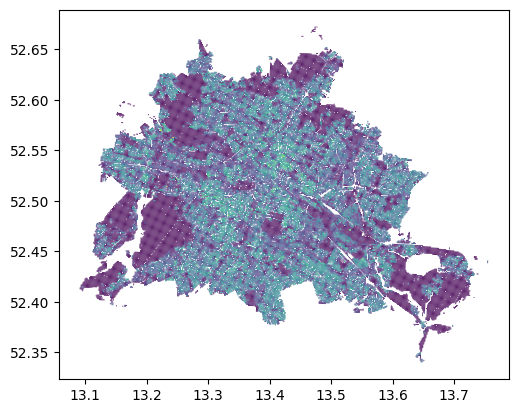

In [198]:
little_berlin = more_berlin[~more_berlin.index.duplicated(keep='first')]
little_berlin.plot(column='population')

In [200]:
little_berlin

veg  roads  water  height_resid  height_nonresid  \
0      165      0      0            30                0   
1      181      0      0            39                0   
2      195      0      0            35                0   
3      204      0      0            29                0   
6      102      0      0            27                0   
...    ...    ...    ...           ...              ...   
71476    0      0      0             0                0   
71477    0      0      0             0                0   
71478    0      0      0             0                0   
71479    0      0      0             0                0   
71480    0      0      0             0                0   

                                                geometry land_use_code  \
0      POLYGON ((13.64540 52.34009, 13.64686 52.34005...         11220   
1      POLYGON ((13.64686 52.34005, 13.64833 52.34000...         11220   
2      POLYGON ((13.64547 52.34099, 13.64694 52.34094...         11220   
3      POLYGON ((13.64694 52.34094, 13.64840 52.34090...         11220   
6      POLYGON ((13.64555 52.34189, 13.64701 52.34184...         11220   
...                                                  ...           ...   
71476  POLYGON ((13.47285 52.66910, 13.47433 52.66906...         32000   
71477  POLYGON ((13.47292 52.67000, 13.47440 52.66995...         23000   
71478  POLYGON ((13.47299 52.67089, 13.47447 52.67085...         23000   
71479  POLYGON ((13.47306 52.67179, 13.47454 52.67175...         23000   
71480  POLYGON ((13.47602 52.67171, 13.47749 52.67166...         32000   

       land_use_area  population  
0       95051.225653   90.136093  
1       26392.319278   90.136093  
2       95051.225653   44.143646  
3       26392.319278   44.143646  
6       95051.225653   44.143646  
...              ...         ...  
71476   13737.505410    0.000000  
71477   25948.699349    0.000000  
71478   25948.699349    0.000000  
71479   25948.699349    0.000000  
71480   11678.106351    0.000000  

[71387 rows x 9 columns]

In [201]:
from assign_y import assign_y
y_value = gpd.read_file('../raw_data/berlin_y.csv',sep='\t')
y_value

gbifID                            datasetKey  \
0       2832407287  8a863029-f435-446a-821e-275f4f641165   
1       3906824794  8a863029-f435-446a-821e-275f4f641165   
2       2836060223  8a863029-f435-446a-821e-275f4f641165   
3       2832961073  8a863029-f435-446a-821e-275f4f641165   
4       2839312403  8a863029-f435-446a-821e-275f4f641165   
...            ...                                   ...   
570142   922948989  6ac3f774-d9fb-4796-b3e9-92bf6c81c084   
570143   920607467  6ac3f774-d9fb-4796-b3e9-92bf6c81c084   
570144  3447345509  6ac3f774-d9fb-4796-b3e9-92bf6c81c084   
570145  1899878384  6ac3f774-d9fb-4796-b3e9-92bf6c81c084   
570146  2236674872  6ac3f774-d9fb-4796-b3e9-92bf6c81c084   

                                         occurrenceID   kingdom        phylum  \
0        https://observation.org/observation/81084816  Animalia      Chordata   
1       https://observation.org/observation/253443812  Animalia      Chordata   
2       https://observation.org/observation/114911820  Animalia      Chordata   
3       https://observation.org/observation/138429429  Animalia      Chordata   
4       https://observation.org/observation/104623093  Animalia      Chordata   
...                                               ...       ...           ...   
570142                                                 Animalia      Chordata   
570143                                                 Animalia      Chordata   
570144                                                 Animalia      Chordata   
570145                                                 Animalia      Chordata   
570146                                                  Plantae  Tracheophyta   

                class           order          family           genus  \
0                Aves   Passeriformes    Fringillidae       Carduelis   
1                Aves   Passeriformes        Corvidae          Corvus   
2                Aves      Piciformes         Picidae     Dendrocopos   
3                Aves   Passeriformes    Fringillidae  Coccothraustes   
4                Aves   Passeriformes        Turdidae          Turdus   
...               ...             ...             ...             ...   
570142           Aves   Passeriformes  Phylloscopidae    Phylloscopus   
570143           Aves  Pelecaniformes        Ardeidae           Ardea   
570144           Aves   Passeriformes         Paridae       Cyanistes   
570145           Aves   Passeriformes      Passeridae          Passer   
570146  Magnoliopsida       Asterales      Asteraceae          Bellis   

                              species  ... dateIdentified       license  \
0                 Carduelis carduelis  ...                 CC_BY_NC_4_0   
1                       Corvus cornix  ...                 CC_BY_NC_4_0   
2                   Dendrocopos major  ...                 CC_BY_NC_4_0   
3       Coccothraustes coccothraustes  ...                 CC_BY_NC_4_0   
4                       Turdus merula  ...                 CC_BY_NC_4_0   
...                               ...  ...            ...           ...   
570142         Phylloscopus collybita  ...                    CC_BY_4_0   
570143                  Ardea cinerea  ...                    CC_BY_4_0   
570144            Cyanistes caeruleus  ...                    CC_BY_4_0   
570145              Passer domesticus  ...                    CC_BY_4_0   
570146                Bellis perennis  ...                    CC_BY_4_0   

                               rightsHolder   recordedBy typeStatus  \
0       Stichting Observation International   User 87682              
1       Stichting Observation International  User 331420              
2       Stichting Observation International    User 5757              
3       Stichting Observation International    User 2164              
4       Stichting Observation International   User 44576              
...                                     ...          ...        ...   
570142                                     

In [202]:
y_value = y_value[['decimalLongitude','decimalLatitude']]
y_gdf = gpd.GeoDataFrame(y_value,geometry=gpd.points_from_xy(x=y_value['decimalLongitude'],y=y_value['decimalLatitude']),crs='epsg:4326')
y_gdf

decimalLongitude decimalLatitude                   geometry
0             13.461955       52.547599  POINT (13.46195 52.54760)
1             13.096624       52.424582  POINT (13.09662 52.42458)
2             13.389546       52.534192  POINT (13.38955 52.53419)
3              13.34784       52.510258  POINT (13.34784 52.51026)
4             13.407907       52.517157  POINT (13.40791 52.51716)
...                 ...             ...                        ...
570142        13.369331       52.401737  POINT (13.36933 52.40174)
570143        13.417997        52.43409  POINT (13.41800 52.43409)
570144        13.540564       52.548069  POINT (13.54056 52.54807)
570145        13.488293       52.466469  POINT (13.48829 52.46647)
570146        13.415805       52.564758  POINT (13.41581 52.56476)

[570147 rows x 3 columns]

In [203]:
all_berlin = gpd.sjoin(little_berlin,y_gdf)
all_berlin

veg  roads  water  height_resid  height_nonresid  \
3      204      0      0            29                0   
3      204      0      0            29                0   
3      204      0      0            29                0   
21     207      0      0            33                0   
26     122      0      0            39                0   
...    ...    ...    ...           ...              ...   
71473    0      0      0             0                0   
71473    0      0      0             0                0   
71471    0      0      0             0                0   
71471    0      0      0             0                0   
71476    0      0      0             0                0   

                                                geometry land_use_code  \
3      POLYGON ((13.64694 52.34094, 13.64840 52.34090...         11220   
3      POLYGON ((13.64694 52.34094, 13.64840 52.34090...         11220   
3      POLYGON ((13.64694 52.34094, 13.64840 52.34090...         11220   
21     POLYGON ((13.64005 52.34655, 13.64152 52.34651...         11220   
26     POLYGON ((13.64159 52.34741, 13.64306 52.34736...         11220   
...                                                  ...           ...   
71473  POLYGON ((13.46982 52.66829, 13.47130 52.66824...         12100   
71473  POLYGON ((13.46982 52.66829, 13.47130 52.66824...         12100   
71471  POLYGON ((13.47271 52.66730, 13.47418 52.66726...         12100   
71471  POLYGON ((13.47271 52.66730, 13.47418 52.66726...         12100   
71476  POLYGON ((13.47285 52.66910, 13.47433 52.66906...         32000   

       land_use_area  population  index_right decimalLongitude decimalLatitude  
3       26392.319278   44.143646       188353        13.647099       52.341098  
3       26392.319278   44.143646       126428        13.647855       52.341111  
3       26392.319278   44.143646       125656         13.64729       52.341412  
21      74207.660991   57.022282       440099        13.640841       52.346795  
26      74207.660991   17.691589       347445         13.64208       52.347505  
...              ...         ...          ...              ...             ...  
71473   49497.745408    0.000000       493304        13.471274       52.668577  
71473   49497.745408    0.000000       191644        13.470048        52.66881  
71471   22249.799060    0.000000       492328        13.472793       52.667312  
71471   22249.799060    0.000000       496138        13.472793       52.667312  
71476   13737.505410    0.000000        51183        13.473755       52.669379  

[467008 rows x 12 columns]

In [215]:
y_col = all_berlin.groupby(all_berlin.index).count()
y_col.columns = ['y', 'roads', 'water', 'height_resid', 'height_nonresid', 'geometry',
       'land_use_code', 'land_use_area', 'population', 'index_right',
       'decimalLongitude', 'decimalLatitude']
y_col = y_col['y']
y_col

3         3
21        1
25        1
26        1
27        2
         ..
71470     4
71471     2
71472     2
71473    12
71476     1
Name: y, Length: 25368, dtype: int64

In [222]:
done_berlin = pd.merge(little_berlin,y_col,how='left',left_index=True,right_index=True)
done_berlin

veg  roads  water  height_resid  height_nonresid  \
0      165      0      0            30                0   
1      181      0      0            39                0   
2      195      0      0            35                0   
3      204      0      0            29                0   
6      102      0      0            27                0   
...    ...    ...    ...           ...              ...   
71476    0      0      0             0                0   
71477    0      0      0             0                0   
71478    0      0      0             0                0   
71479    0      0      0             0                0   
71480    0      0      0             0                0   

                                                geometry land_use_code  \
0      POLYGON ((13.64540 52.34009, 13.64686 52.34005...         11220   
1      POLYGON ((13.64686 52.34005, 13.64833 52.34000...         11220   
2      POLYGON ((13.64547 52.34099, 13.64694 52.34094...         11220   
3      POLYGON ((13.64694 52.34094, 13.64840 52.34090...         11220   
6      POLYGON ((13.64555 52.34189, 13.64701 52.34184...         11220   
...                                                  ...           ...   
71476  POLYGON ((13.47285 52.66910, 13.47433 52.66906...         32000   
71477  POLYGON ((13.47292 52.67000, 13.47440 52.66995...         23000   
71478  POLYGON ((13.47299 52.67089, 13.47447 52.67085...         23000   
71479  POLYGON ((13.47306 52.67179, 13.47454 52.67175...         23000   
71480  POLYGON ((13.47602 52.67171, 13.47749 52.67166...         32000   

       land_use_area  population    y  
0       95051.225653   90.136093  NaN  
1       26392.319278   90.136093  NaN  
2       95051.225653   44.143646  NaN  
3       26392.319278   44.143646  3.0  
6       95051.225653   44.143646  NaN  
...              ...         ...  ...  
71476   13737.505410    0.000000  1.0  
71477   25948.699349    0.000000  NaN  
71478   25948.699349    0.000000  NaN  
71479   25948.699349    0.000000  NaN  
71480   11678.106351    0.000000  NaN  

[71387 rows x 10 columns]

<Axes: >

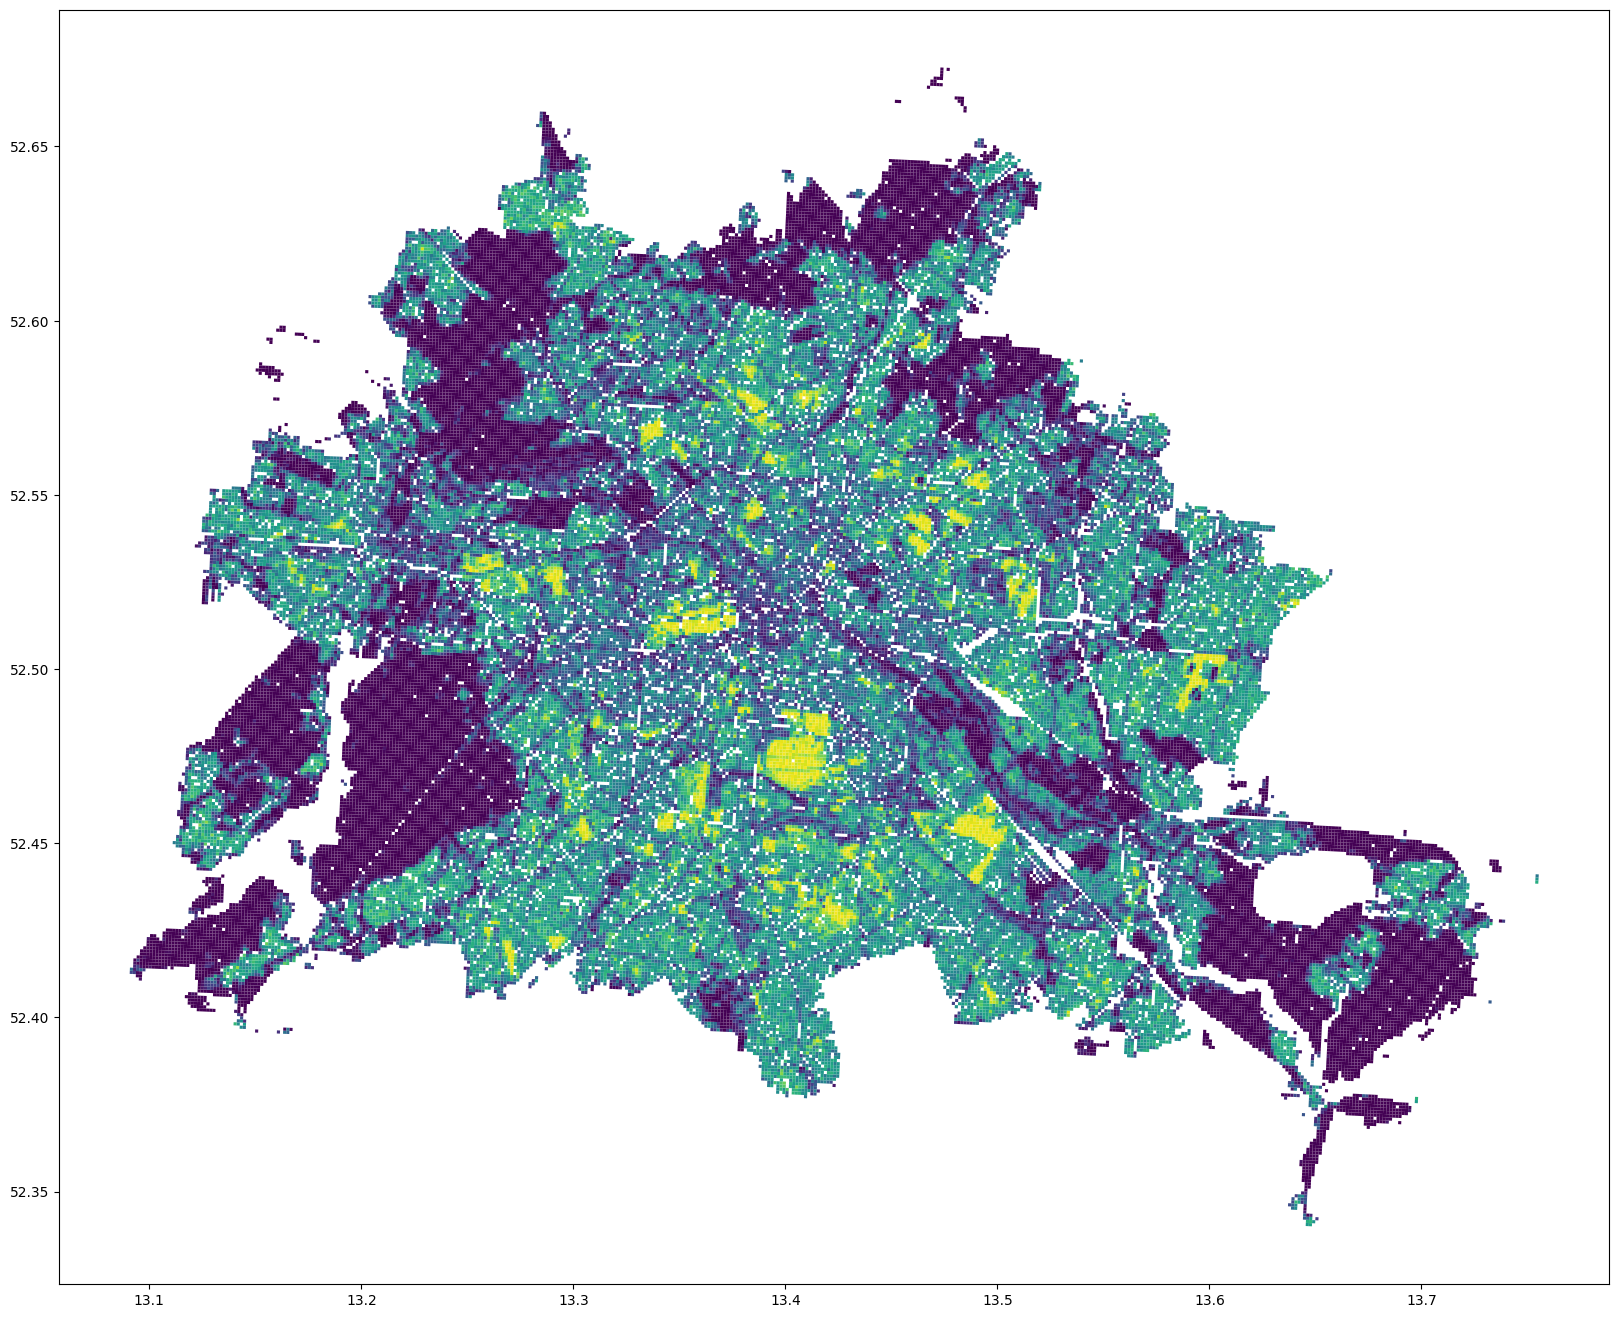

In [239]:
done_berlin.plot(column='veg',figsize=(20,20))

<Axes: >

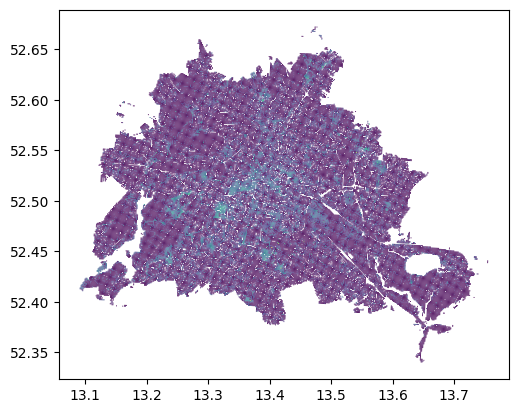

In [224]:
done_berlin['log_y'] = np.log(done_berlin['y'])
done_berlin.plot(column='log_y')

In [225]:
done_berlin.to_file('../raw_data/berlin_with_features.json',driver='GeoJSONSeq')

In [233]:
gpd.read_file('../output.json')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "fiona/ogrext.pyx", line 136, in fiona.ogrext.gdal_open_vector
  File "fiona/_err.pyx", line 291, in fiona._err.exc_wrap_pointer
fiona._err.CPLE_OpenFailedError: '../output.json' not recognized as a supported file format.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zilikons/.pyenv/versions/3.10.6/envs/demeter/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/dy/8nkgqf653sggg31kzy33mjdr0000gn/T/ipykernel_43898/510531353.py", line 1, in <module>
    gpd.read_file('../output.json')
  File "/Users/zilikons/.pyenv/versions/3.10.6/envs/demeter/lib/python3.10/site-packages/geopandas/io/file.py", line 259, in _read_file
    return _read_file_fiona(
  File "/Users/zilikons/.pyenv/versions/3.10.6/envs/demeter/lib/python3.10/site-packages/geopandas/io/file.py", line 303,

In [48]:
test = gpd.read_file('../data/berlin_with_features.json')

In [67]:
np.asarray(test.geometry[0].exterior.xy).T

array([[13.6453986, 52.3400915],
       [13.6468642, 52.3400465],
       [13.6469379, 52.3409439],
       [13.6454723, 52.3409889],
       [13.6453986, 52.3400915]])

In [60]:
from shapely.geometry import Polygon

p1 = Polygon([(0, 0), (1, 0), (1, 1)])
p2 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
p3 = Polygon([(1, 1), (2, 1), (2, 2), (1, 2)])
s = gpd.GeoSeries([p1, p2, p3])

In [61]:
np.asarray(s.geometry[0].exterior)

array(<LINEARRING (0 0, 1 0, 1 1, 0 0)>, dtype=object)

In [64]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import shapely
import matplotlib.pyplot as plt

def plot_polygon_collection(ax, geoms, values=None, colormap='Set1',  facecolor=None, edgecolor=None,
                            alpha=0.5, linewidth=1.0, **kwargs):
    """ Plot a collection of Polygon geometries """
    patches = []

    for poly in geoms:

        a = np.asarray(poly.exterior)
        if poly.has_z:
            poly = shapely.geometry.Polygon(zip(*poly.exterior.xy))

        patches.append(Polygon(a))

    patches = PatchCollection(patches, facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, alpha=alpha, **kwargs)

    if values is not None:
        patches.set_array(values)
        patches.set_cmap(colormap)

    ax.add_collection(patches, autolim=True)
    ax.autoscale_view()
    return patches

ValueError: not enough values to unpack (expected 2, got 0)

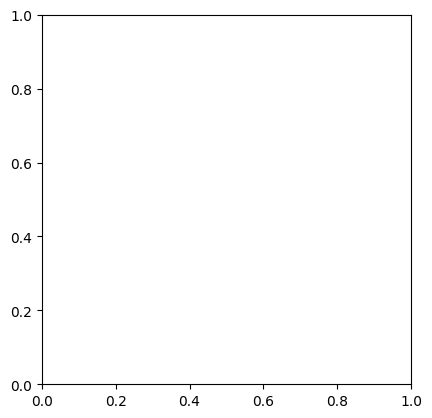

In [65]:
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
col = plot_polygon_collection(ax, s.geometry)